In [1]:
# Imports
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
from PIL import Image as im
import sklearn
from sklearn import linear_model, datasets, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import time
import tensorflow as tf
from tensorflow import keras
import nbconvert
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential

In [12]:
# Paramètres
n, m = (30, 30) #taille des images
p = 42 #nombre de classes (si on utilise toute la BDD les calculs sont longs)

In [13]:
# Fonction permettant de lire les données (fournie par les auteurs de la base de données)
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(p):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

In [14]:
# Lecture des données
data = (readTrafficSigns("C:/Users/guill/PycharmProjects/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images"))

# Création du DataFrame
df = pd.DataFrame(data, ["data", "target"])
df = df.transpose()

# Resizing des images
for index, row in df.iterrows():
    image = row['data']
    resized = im.fromarray(image).resize((n,m))
    resized = np.asarray(resized)
    df.at[index, 'data'] = np.array(resized)

    
# Découpage du jeu de données 
X_train, X_test, y_train, y_test = train_test_split(df["data"], df["target"], test_size=0.33)

# Conversion
X_train, X_test, y_train, y_test = X_train.tolist(), X_test.tolist(), (y_train.astype(int)).tolist(), (y_test.astype(int)).tolist()
indices = X_train.index
indices2 = X_test.index

# Création des labels en vecteurs (ex : [0, 1, 0, 0, 0]) et conversion en tenseur tensorflow
y_trainflow = []
for i in range(len(y_train)):
    L = [0]*p
    L[y_train[i]] = 1
    y_trainflow.append(L)
y_trainflow = np.stack(np.array(y_trainflow))
y_train = tf.constant(y_trainflow)

y_testflow = []
for i in range(len(y_test)):
    L = [0]*p
    L[y_test[i]] = 1
    y_testflow.append(L)
y_testflow = np.stack(np.array(y_testflow))
y_test = tf.constant(y_testflow)


# On aplatit les images et on les convertit en tenseur tensorflow 
X_train = np.stack(np.array(X_train))/255
X_train = tf.constant(X_train)

X_test = np.stack(np.array(X_test))/255
X_test = tf.constant(X_test)

In [15]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(n,m,3)),  # Utiliser Input pour définir la forme d'entrée
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(p, activation='softmax')  # Assurez-vous que p correspond au nombre de classes de votre problème
])

# Compiler le modèle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1024)             

164/164 [==============================] - 0s 2ms/step


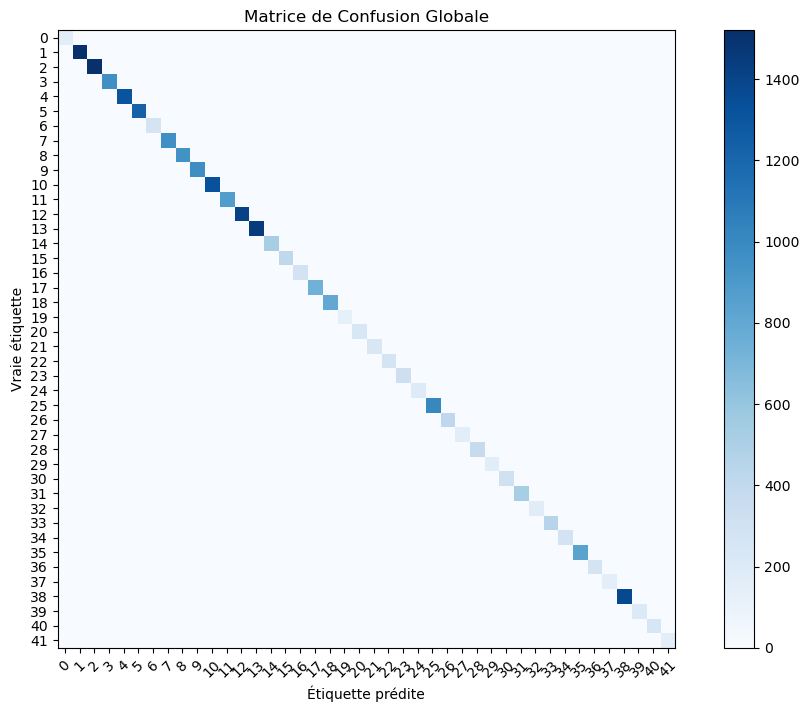

              precision    recall  f1-score   support

    Classe 0       1.00      1.00      1.00       159
    Classe 1       1.00      1.00      1.00      1513
    Classe 2       1.00      1.00      1.00      1523
    Classe 3       0.99      1.00      1.00       960
    Classe 4       1.00      1.00      1.00      1311
    Classe 5       1.00      0.99      0.99      1236
    Classe 6       1.00      1.00      1.00       267
    Classe 7       1.00      0.99      1.00       961
    Classe 8       0.99      1.00      0.99       950
    Classe 9       1.00      1.00      1.00       973
   Classe 10       1.00      1.00      1.00      1328
   Classe 11       1.00      1.00      1.00       869
   Classe 12       1.00      1.00      1.00      1414
   Classe 13       1.00      1.00      1.00      1454
   Classe 14       1.00      1.00      1.00       520
   Classe 15       0.99      1.00      1.00       416
   Classe 16       1.00      0.99      1.00       277
   Classe 17       1.00    

In [20]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Supposons que X_train et y_train sont déjà définis, ainsi que ton modèle CNN `model`

k = 5
kf = KFold(n_splits=k, shuffle=True)

# Initialisation
all_predictions = []
all_true_labels = []
all_pred_prob = []  # Pour stocker les probabilités de prédiction de chaque classe

for train_index, test_index in kf.split(X_train.numpy()):
    train_indices_tensor = tf.constant(train_index)
    test_indices_tensor = tf.constant(test_index)
    
    X_train_fold = tf.gather(X_train, train_indices_tensor)
    X_test_fold = tf.gather(X_train, test_indices_tensor)
    y_train_fold = tf.gather(y_train, train_indices_tensor)
    y_test_fold = tf.gather(y_train, test_indices_tensor)
    
    # Entraînement du modèle
    model.fit(X_train_fold, y_train_fold, epochs=5, verbose=0)
    
    # Prédictions
    pred_prob = model.predict(X_test_fold)  # Probabilités prédites
    predicted_classes = np.argmax(pred_prob, axis=1)
    true_classes = np.argmax(y_test_fold.numpy(), axis=1)
    
    all_pred_prob.extend(pred_prob)  # Accumulation des probabilités prédites
    all_predictions.extend(predicted_classes)
    all_true_labels.extend(true_classes)

# Binarisation des étiquettes réelles pour le calcul de l'AUC
y_bin = label_binarize(all_true_labels, classes=np.unique(all_true_labels))
if y_bin.shape[1] == 1:  # Cas de classification binaire
    y_bin = np.hstack((1 - y_bin, y_bin))

# Calcul de l'AUC pour chaque classe et traitement du cas multiclasse
auc_scores = roc_auc_score(y_bin, all_pred_prob, average=None, multi_class="ovr")

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 7))
conf_matrix = confusion_matrix(all_true_labels, all_predictions)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de Confusion Globale')
plt.colorbar()
tick_marks = np.arange(len(np.unique(all_true_labels)))
plt.xticks(tick_marks, np.unique(all_true_labels), rotation=45)
plt.yticks(tick_marks, np.unique(all_true_labels))
plt.tight_layout()
plt.ylabel('Vraie étiquette')
plt.xlabel('Étiquette prédite')
plt.show()

# Affichage des métriques par classe et des scores AUC
print(classification_report(all_true_labels, all_predictions, target_names=[f'Classe {i}' for i in np.unique(all_true_labels)]))
for i, score in enumerate(auc_scores):
    print(f'Classe {i} AUC: {score:.3f}')


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

def create_model(dropout_rate, activation, learning_rate):
    model = Sequential([
        Input(shape=(n, m, 3)),  # Utilisez Input pour définir la forme d'entrée
        Conv2D(32, kernel_size=(3, 3), activation=activation),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(dropout_rate),
        Flatten(),
        Dense(128, activation=activation),
        Dropout(dropout_rate),
        Dense(p, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'], loss='categorical_crossentropy')
    return model


# Création de l'instance KerasClassifier
model = KerasClassifier(model=create_model, epochs=5, verbose = 0, model__learning_rate=0.001, model__dropout_rate=0.5, model__activation='relu')

# Paramètres à optimiser avec le préfixe `model__`
param_distributions = {
    'model__learning_rate': [0.001, 0.01],
    'model__dropout_rate': [0.1, 0.5],
    'model__activation': ['relu', 'tanh']
}

# Configuration de RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_distributions, n_iter=2, cv=3, error_score='raise')

# Faites attention ici à utiliser les données correctement préparées
X_train_np = X_train.numpy()
y_train_np = y_train.numpy()
X_test_np = X_test.numpy()
y_test_np = y_test.numpy()
random_search.fit(X_train_np, y_train_np)

best_model = random_search.best_estimator_
accuracy = best_model.score(X_test_np, y_test_np)
print("Test Accuracy:", accuracy)


ValueError: Could not interpret metric identifier: loss

In [ ]:
à voir : limiter le gridsearch (utiliser bysearch), hyperparamètre dropout, sortie de réseau deep + HOG -> ML. évaluations : matrice de confusion + recall et précision par classe (critique ou pas) + AUC ? 

In [ ]:
contraste normalisation with gaussien kernels ?